# Writeup

The notebook contains the final writeup for our project, including visualizations from data exploration and our final model.  Our project used the Inpatient Prospective Payment Systems (IPPS) data from 2013.  This data includes information about the top 100 types of inpatient procedures, or Diagnosis-Related Groups (DRGs), and the average costs at each of over 3,000 providers across the United States.  It's worth noting that not all providers had patients in every DRG, so we were working with ~150,000 rows of data rather than 300,000+.  The goal of our project was to predict the cost of a procedure given the DRG and provider geographic data.  The scenario in which this would be useful is if a patient wanted to know how much a procedure would cost, but data for their specific provider is not available.

## Style Fix

In [1]:
%%html
<style>
table {float:left}
</style>

## Imports

In [2]:
%matplotlib inline
import loadAndClean
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Load Cleaned Data

In a script we wrote, `loadAndClean.py`, we load the IPPS data and do some preprocessing on it.  We create numerical columns from values that were originally strings, numerically encode categorical features, and merge in our geocoding data.  The geocoding data is latitude and longitude values obtained by running the provider addresses through the Google Maps API.

In [3]:
X = loadAndClean.loadAndClean()
X.head(3)

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Provider HRR,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Average Covered Charges Num,Average Total Payments Num,Average Medicare Payments Num,DRG Code,Provider HRR Num,Latitude,Longitude
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,98,$37988.98,$5872.19,$4838.32,37988.98,5872.19,4838.32,39,2,31.216725,-85.363068
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,34,$15554.88,$6053.29,$5255.65,15554.88,6053.29,5255.65,39,1,34.204811,-86.101860
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,30,$40380.10,$5319.83,$4150.87,40380.10,5319.83,4150.87,39,1,34.793845,-87.683155


There are three columns in the data that we were interested in predicting:  _Average Covered Charges_ (how much the provider charges), _Average Total Payments_ (how much the provider actually gets paid), and _Average Medicare Payments_ (how much of that Medicare pays).  We decided to focus mainly on the third amount when developing our models because we thought it would be the easiest to predict since Medicare uses a formula that includes factors such as procedure and provider wage index to determine this amount (with exceptions for special cases).

## Data Exploration

Before creating our models, we explored and visualized different aspects of the data.  To see if it would be reasonable to predict the Medicare payment for a procedure, we looked at the data by DRG and geography.  First, since creating visuals for all 100 DRGs would be a bit much, we looked at the most common procedures to select a subset to look at.

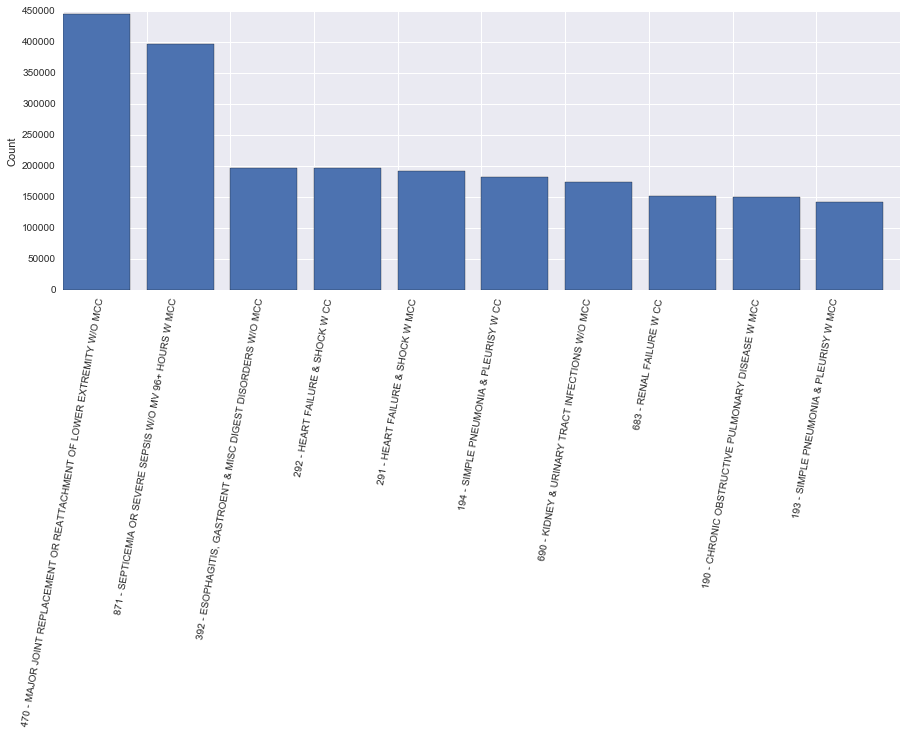

In [4]:
dischargeCountByDrg = []
for drg_name,drg in X.groupby('DRG Definition'):
    dischargeCountByDrg.append((drg['Total Discharges'].sum(), drg_name))
sortedDrgByCount = sorted(dischargeCountByDrg, reverse=True)

plt.figure(figsize=(15, 5))
top10 = sortedDrgByCount[:10]
plt.ylabel('Count')
plt.bar(np.arange(len(top10)), [x[0] for x in top10])
plt.xticks(np.arange(len(top10)), [x[1] for x in top10], rotation=80);

We'll only use the top 4 DRGs in the rest of our visualizations, starting with a histogram of cost.

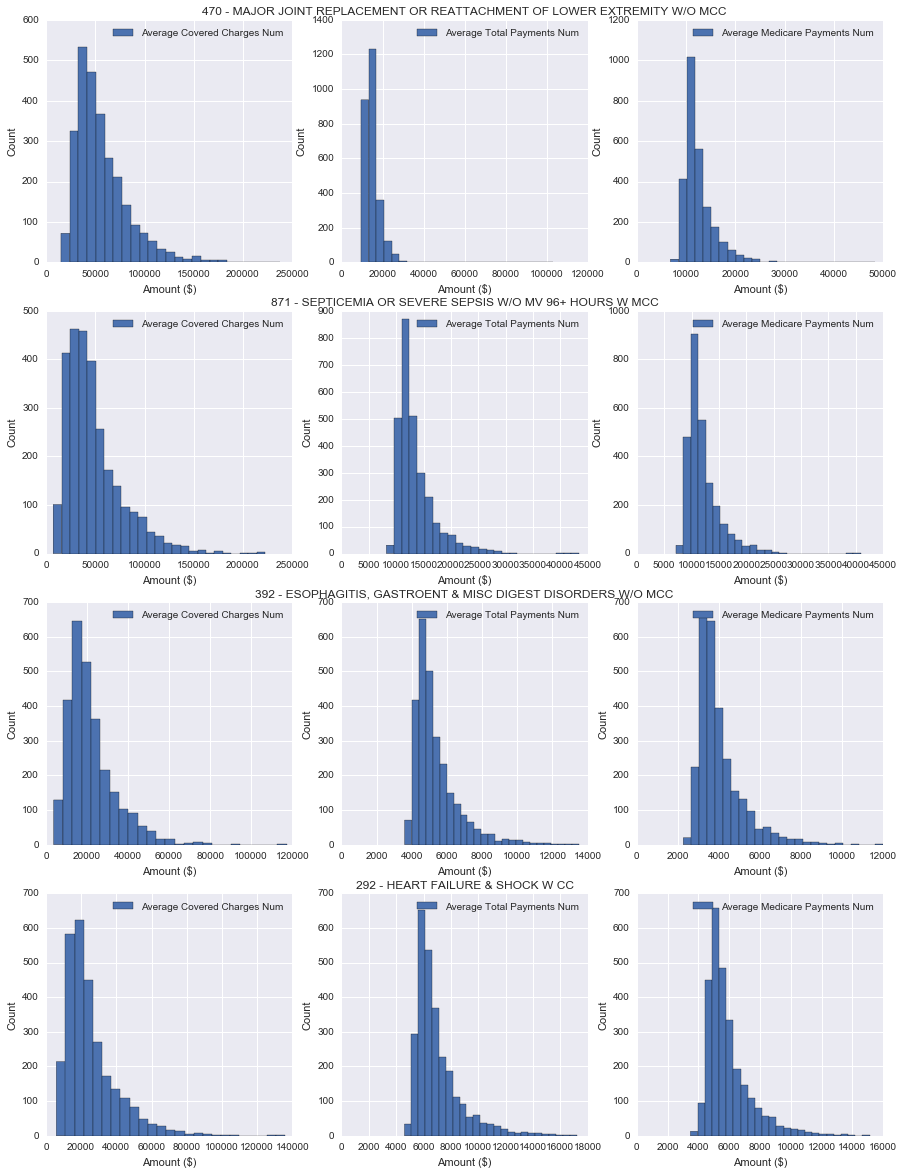

In [5]:
drg_codes = [470, 871, 392, 292]
cols = ['Average Covered Charges Num', 'Average Total Payments Num', 'Average Medicare Payments Num']

plt.figure(figsize=(15,5*len(drg_codes)))
i = 1
for drg_code in drg_codes:
    drg = X[X['DRG Code'] == drg_code]
    drg_name = drg['DRG Definition'].values[0]
    for j,col in enumerate(cols):
        plt.subplot(len(drg_codes), 3, i)
        drg[col].hist(bins=25)
        xmin, xmax = plt.xlim()
        plt.xlim(0, xmax)
        plt.xlabel('Amount ($)')
        plt.ylabel('Count')
        plt.legend([col])
        if j == 1:
            plt.title(drg_name)
        i += 1

There is clearly a correlation between DRG and cost, so using the DRG to predict the cost seems likely to be effective.  Next, we'll look at the geographic data and how it relates to cost.

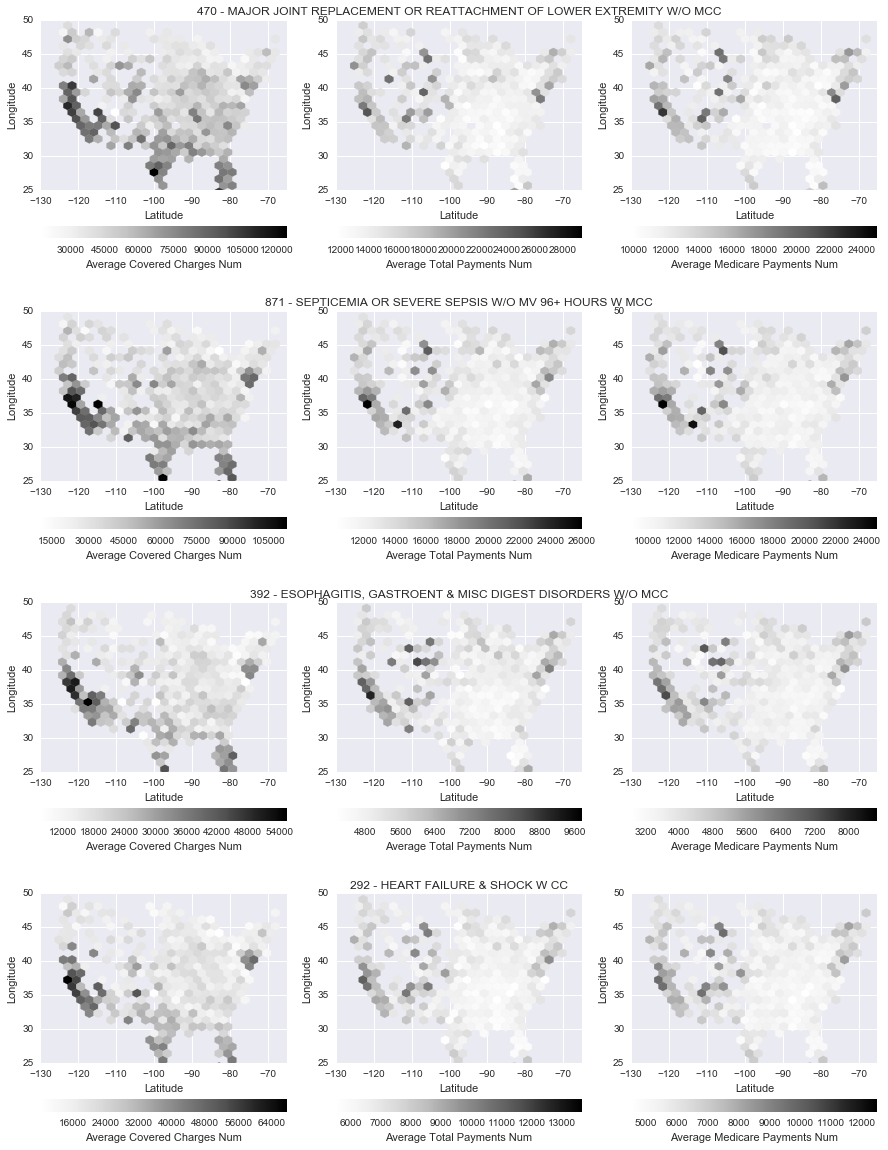

In [6]:
drg_codes = [470, 871, 392, 292]
cols = ['Average Covered Charges Num', 'Average Total Payments Num', 'Average Medicare Payments Num']

plt.figure(figsize=(15,5*len(drg_codes)))
i = 1
for drg_code in drg_codes:
    drg = X[X['DRG Code'] == drg_code]
    drg_name = drg['DRG Definition'].values[0]
    for j,col in enumerate(cols):
        plt.subplot(len(drg_codes), 3, i)
        plt.hexbin(drg['Longitude'], drg['Latitude'], C=drg[col], gridsize=40)
        plt.xlabel('Latitude')
        plt.ylabel('Longitude')
        cbar = plt.colorbar(orientation='horizontal')
        cbar.set_label(col)
        plt.axis((-130,-65,25,50))
        if j == 1:
            plt.title(drg_name)
        i += 1

It appears that there are clusterings of similar costs, so using geographic data should also be helpful in making our predictions.

## Model

For our models, we used root mean squared error (RMSE) as our metric for success.  Because this is an error, a lower score is better.

### Cross Validation Function

In order to test our models, we created a helper function for cross validation.  It takes all of the data from 500 randomly-selected providers to use as the test data, but also checks that each procedure is present in both the train and test data.

In [7]:
def crossVal(clf, X, predictors, y_col='Average Medicare Payments Num', cv=3):
    random.seed(2016)
    scores = []
    for i in range(cv):
        while True:
            testIds = random.sample(X['Provider Id'].unique(),500)
            testData = X[X['Provider Id'].isin(testIds)]
            trainData = X[~X['Provider Id'].isin(testIds)]
            if len(testData['DRG Code'].unique()) == len(X['DRG Code'].unique()) and len(trainData['DRG Code'].unique()) == len(X['DRG Code'].unique()):
                break
        X_train = trainData[predictors]
        y_train = trainData[y_col]
        X_test = testData[predictors]
        y_test = testData[y_col]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        scores.append(mean_squared_error(y_test, predictions)**0.5)
        print scores[i]
    print "Average RMSE: ${:,.2f}".format(np.mean(scores))

### Grouped Baseline

This baseline simply estimates the cost by guessing the average for the given DRG code; it does not use any geographic data.

In [8]:
class grouped_baseline(object):
    def __init__(self):
        self.has_fit = False

    def fit(self, X_train, y_train):
        X_train = X_train.copy()
        X_train['Cost'] = y_train
        groups = X_train.groupby(['DRG Code'])

        # Average the cost for each DRG
        self.drg_costs = {}
        for ind,data in groups:
            self.drg_costs[ind] = data['Cost'].mean()

        self.has_fit = True

    def predict(self, X_test):
        if self.has_fit:
            return X_test['DRG Code'].apply(lambda x: self.drg_costs[x])
        return None

In [9]:
alg = grouped_baseline()
crossVal(alg, X, ['DRG Code'], cv=5)

2991.62462984
3050.52401047
2545.25064968
2727.71502441
2754.0896391
Average RMSE: $2,813.84


Guessing the average for the given DRG code yields a RMSE of ~$2,800. We expect all of our real models to have a lower RMSE than this once they account for geographic data. 

### Best Model

After exploring different models and doing parameter sweeps, the best model we were able to find was a Random Forest with 200 trees, a max_depth of 22, and a min_sample_split of 18.  This yielded a RMSE of ~$2,100, a 25% improvement over our baseline model.

In [10]:
alg = RandomForestRegressor(n_estimators=200, max_depth=22, min_samples_split=18, n_jobs=-1)
crossVal(alg, X, ['Latitude','Longitude','DRG Code'], cv=5)

2056.65988644
2255.13139147
1978.65944321
2122.11146446
2165.4436405
Average RMSE: $2,115.60


## Conclusion

Our model performed better than the grouped baseline, but not as well as we hoped. We hypothesize that the reason our error remians high is because the wage index Medicare uses to calculate payment is only influenced a small amount by geography on a latitude and longitude level compared to on a neighborhood level. It's possible that this model could be improved by factoring in information from another source about the area around a given hospital, such as cost of living.